In [ ]:
import keras

Test RMSE: 14.442806778048519


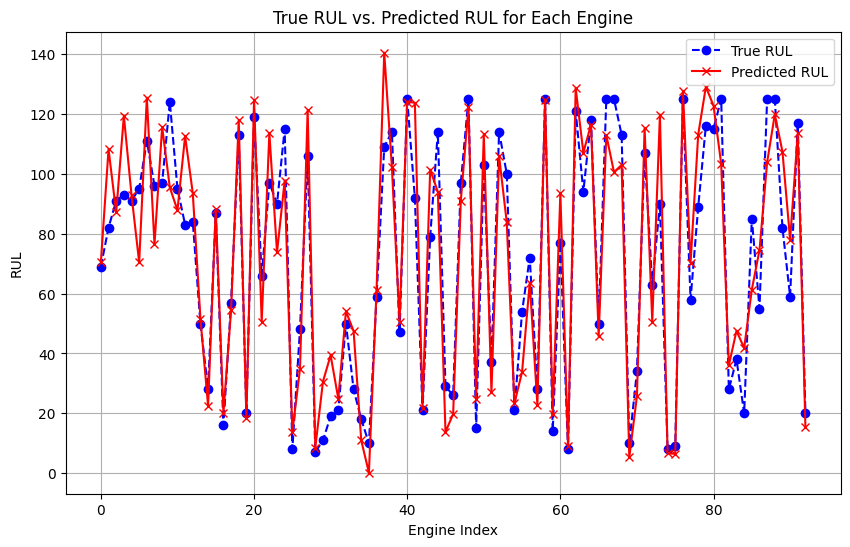

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
from pyts.image import RecurrencePlot
import matplotlib.pyplot as plt

def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

# Define paths
current_dir = os.getcwd()
train_FD001_path = current_dir +'/cmapss/train_FD001.csv'
test_FD001_path = current_dir +'/cmapss/test_FD001.csv'
RUL_FD001_path = current_dir+'/cmapss/RUL_FD001.txt'
model_path = current_dir + '/2DCNNSLTM(Epochs-100,learning_rate=0.05, batch_size=32, sequence 50).h5'

# Load train and test data
train_FD = pd.read_csv(train_FD001_path, sep=' ', header=None).drop([26, 27], axis=1)
train_FD.columns = ['unit_nr', 'cycles', 'os_1', 'os_2', 'os_3'] + ['sensor_{0:02d}'.format(s + 1) for s in range(21)]
test_FD = pd.read_csv(test_FD001_path, sep=' ', header=None).drop([26, 27], axis=1)
test_FD.columns = ['unit_nr', 'cycles', 'os_1', 'os_2', 'os_3'] + ['sensor_{0:02d}'.format(s + 1) for s in range(21)]
RUL_FD = pd.read_csv(RUL_FD001_path, sep=' ', header=None)
RUL_FD = RUL_FD.dropna(axis=1, how='all')
RUL_FD.columns = ['RUL_truth']

# Calculate RUL and append to train data
mapper = {}
for unit_nr in train_FD['unit_nr'].unique():
    mapper[unit_nr] = train_FD['cycles'].loc[train_FD['unit_nr'] == unit_nr].max()

train_FD['RUL'] = train_FD['unit_nr'].apply(lambda nr: mapper[nr]) - train_FD['cycles']
piecewise_lin_ref = 125
train_FD['RUL'] = train_FD['RUL'].apply(lambda x: x if x <= piecewise_lin_ref else piecewise_lin_ref)
RUL_FD['RUL_truth'] = RUL_FD['RUL_truth'].apply(lambda x: x if x <= piecewise_lin_ref else piecewise_lin_ref)

# Min-Max normalization
min_max_scaler = preprocessing.MinMaxScaler()

# For the training set
cols_normalize = train_FD.columns.difference(['unit_nr', 'cycles', 'os_1', 'os_2', 'RUL'])
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_FD[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_FD.index)
join_df = train_FD[train_FD.columns.difference(cols_normalize)].join(norm_train_df)
train_FD = join_df.reindex(columns=train_FD.columns)

# For the test set
cols_normalize_test = test_FD.columns.difference(['unit_nr', 'cycles', 'os_1', 'os_2'])
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_FD[cols_normalize_test]), 
                            columns=cols_normalize_test, 
                            index=test_FD.index)
test_join_df = test_FD[test_FD.columns.difference(cols_normalize_test)].join(norm_test_df)
test_FD = test_join_df.reindex(columns=test_FD.columns)
test_FD = test_FD.reset_index(drop=True)

# Exclude columns which only have NaN as value or constant values
cols_nan = train_FD.columns[train_FD.isna().any()].tolist()
cols_const = [col for col in train_FD.columns if len(train_FD[col].unique()) <= 2]
sensor_drop = ['sensor_01', 'sensor_05', 'sensor_06', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']

train_FD = train_FD.drop(columns=cols_const + cols_nan + sensor_drop)
test_FD = test_FD.drop(columns=cols_const + cols_nan + sensor_drop)

# Specify the columns to be used
sequence_cols_train = train_FD.columns.difference(['unit_nr', 'cycles', 'os_1', 'os_2', 'RUL'])
sequence_cols_test = test_FD.columns.difference(['unit_nr', 'os_1', 'os_2', 'cycles'])

# Generator for the sequences
sequence_length = 50

def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

# Generate sequences for the training set
seq_gen = (list(gen_sequence(train_FD[train_FD['unit_nr'] == id], sequence_length, sequence_cols_train))
           for id in train_FD['unit_nr'].unique())
seq_array_train = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array_train = seq_array_train.transpose(0, 2, 1)

label_gen = [gen_labels(train_FD[train_FD['unit_nr'] == id], sequence_length, ['RUL'])
             for id in train_FD['unit_nr'].unique()]
label_array_train = np.concatenate(label_gen).astype(np.float32)

# Generate sequences for the test set (only the last sequence for each engine in test set)
seq_array_test_last = [test_FD[test_FD['unit_nr'] == id][sequence_cols_test].values[-sequence_length:]
                       for id in test_FD['unit_nr'].unique() if
                       len(test_FD[test_FD['unit_nr'] == id]) >= sequence_length]
seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last = seq_array_test_last.transpose(0, 2, 1)

# Recurrence plot transformation for training samples
thres_type = None
thres_percentage = 50
flatten = False

rp_train = RecurrencePlot(threshold=thres_type, percentage=thres_percentage, flatten=flatten)
rp_list_train = []
for idx in range(seq_array_train.shape[0]):
    temp_mts = seq_array_train[idx]
    X_rp_temp = rp_train.fit_transform(temp_mts)
    rp_list_train.append(X_rp_temp)
rp_train_samples = np.stack(rp_list_train, axis=0)

# Recurrence plot transformation for test samples
rp_test = RecurrencePlot(threshold=thres_type, percentage=thres_percentage, flatten=flatten)
rp_list_test = []
for idx in range(seq_array_test_last.shape[0]):
    temp_mts = seq_array_test_last[idx]
    X_rp_temp = rp_test.fit_transform(temp_mts)
    rp_list_test.append(X_rp_temp)
rp_test_samples = np.stack(rp_list_test, axis=0)

# Reshape data to fit the model (add channel dimension)
rp_train_samples = rp_train_samples.reshape(rp_train_samples.shape[0], rp_train_samples.shape[1], rp_train_samples.shape[2], rp_train_samples.shape[3], 1)
rp_test_samples = rp_test_samples.reshape(rp_test_samples.shape[0], rp_test_samples.shape[1], rp_test_samples.shape[2], rp_test_samples.shape[3], 1)

# Load the trained model
model = load_model(model_path, compile=False)

# Predict RUL
y_pred_test = model.predict(rp_test_samples).flatten()

# Load true RUL values and mask to get only engines with sufficient sequence length
y_mask = [len(test_FD[test_FD['unit_nr'] == id]) >= sequence_length for id in test_FD['unit_nr'].unique()]
true_rul = RUL_FD['RUL_truth'][y_mask].values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(true_rul, y_pred_test))
print(f"Test RMSE: {rmse}")

# Plot RUL truth vs. predicted RUL for each engine
plt.figure(figsize=(10, 6))
plt.plot(true_rul, marker='o', linestyle='--', color='b', label='True RUL')
plt.plot(y_pred_test, marker='x', linestyle='-', color='r', label='Predicted RUL')
plt.title('True RUL vs. Predicted RUL for Each Engine')
plt.xlabel('Engine Index')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.show()
